### I. Data Import, Cleaning and Processing:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# I downloaded 61 files of well data from https://azwatermaps.azwater.gov/WellReg
# This code chunk combines them all into one data frame and removes duplicates.

df_list = []

file_in = "raw_data/wells"

for i in range(1,62):
    a = str(i)
    temp = pd.read_excel(file_in + a + ".xlsx")
    df_list.append(temp)
    
df = pd.concat(df_list)

df = df.drop_duplicates()

##### Let's look for missing values and data types:

In [3]:
df.dtypes


Registry No. (55-)              int64
GWSI Site ID                  float64
Cadastral                      object
Owner Name                     object
Well Type                      object
Well Depth (ft)               float64
Casing Depth (ft)             float64
Case Dia (in)                 float64
Drill Date                     object
Applicaiton Date       datetime64[ns]
Water Level (ft)              float64
Pump Capacity (GPM)           float64
Pump Data Available            object
Completion Report              object
Log Received                   object
dtype: object

In [4]:
df.isna().sum()

Registry No. (55-)         0
GWSI Site ID           18810
Cadastral                  0
Owner Name                68
Well Type                  0
Well Depth (ft)         2482
Casing Depth (ft)       2680
Case Dia (in)           2618
Drill Date              6757
Applicaiton Date          32
Water Level (ft)        2983
Pump Capacity (GPM)     6851
Pump Data Available        0
Completion Report      15998
Log Received           12396
dtype: int64

In [5]:
# Rename Owner Name to remove spaces
df.rename(columns = {'Owner Name':'Owner'}, inplace=True)

# Fix spelling error
df.rename(columns = {'Applicaiton Date':'Application Date'}, inplace=True)

# Change Drill Date column to datetime type
df['Drill Date'] = pd.to_datetime(df['Drill Date'], errors = 'coerce')
df['Application Date'] = pd.to_datetime(df['Application Date'], errors = 'coerce')

# Remove NaN from the Well Depth, Drill Date, and Owner:
df = df.dropna(subset=['Well Depth (ft)'])
df = df.dropna(subset=['Drill Date'])
df = df.dropna(subset=['Owner'])

# Create new column to express the year drilled:
# I'm using Application Date instead of drill date, as I noticed there
# Are several entries where the Drill Date is listed before the Application Date.
df['Year'] = df['Application Date'].dt.year

# However, there's some data issues with the dates in year 1982. For these, we will use the Drill Date instead. 
df["Year"] = np.where(df["Year"] == "1982", 1982, df['Drill Date'].dt.year)

# we shouldn't have well depth or water level of 0:
df = df.loc[df['Well Depth (ft)'] != 0]
#df = df.loc[df['Well Depth (ft)'] >= 20]

df = df.loc[df['Water Level (ft)'] != 0]
#df = df.loc[df['Water Level (ft)'] >= 20]

In [7]:
# Lets Look at the the well depth statistics in Cochise County:
df["Well Depth (ft)"].describe()
    

count    12286.000000
mean       363.615660
std        291.649412
min          3.000000
25%        160.000000
50%        300.000000
75%        490.000000
max       5679.000000
Name: Well Depth (ft), dtype: float64

In [8]:
# Really? 5679 feet deep?
# This looks like a data error to me. There's only two entries with a depth over 5000 feet. 
# they were both drilled 3 weeks apart in 1982, and the well depth is identical (5679 ft)
# given that the water level is 500 ft, I'm thinking this was a data entry error. 

mx = df[df['Well Depth (ft)'] >= 4500]
mx

,Registry No. (55-),GWSI Site ID,Cadastral,Owner,Well Type,Well Depth (ft),Casing Depth (ft),Case Dia (in),Drill Date,Application Date,Water Level (ft),Pump Capacity (GPM),Pump Data Available,Completion Report,Log Received,Year
35,616445,3.122171e+14,D24031002BDD,"AZ STATE LAND DEPT,",EXEMPT,5679.0,1300.0,11.0,1971-11-01,1982-06-14,500.0,0.0,NO,X,NaN,1971
221,632855,NaN,D24031002DBB,"GERONIMO RANCH, LLC",EXEMPT,5679.0,1800.0,9.0,1971-01-01,1982-05-06,500.0,2.0,NO,X,NaN,1971


In [68]:
# Delete these two entries, and all well depths less than 25 ft. 
df = df[df['Well Depth (ft)'] <= 4500]
df = df[df['Well Depth (ft)'] >= 25]

### Let's group the well owners into sectors: Riverview, Oil Companies, AZ State, City, Federal, Energy (Gas and Electricity),  and Mining:

In [30]:
df_rv = df[df.Owner.str.contains("RIVERVIEW")]

df_oil = df[df.Owner.str.contains("OIL|CONOCO")]

df_energy = df[df.Owner.str.contains("ELECTRIC|POWER|ENERGY|GAS|ARIZONA PUBLIC SERVICE COMPANY|ARIZONA'S G&T COOPERATIVES")]

df_mining = df[df.Owner.str.contains("FREEPORT|MINING|EXCELSIOR|PHELPS DODGE")]

df_az = df[df.Owner.str.contains("ARIZONA DEPARTMENT|ARIZONA DEPT|ARIZONA STATE|AZ STATE|AZ GAME|USAG|ADEQ")]

df_city = df[df.Owner.str.contains("CITY")]

df_fed = df[df.Owner.str.contains("USDA|CORONADO|NATIONAL FOREST|BLM|GEOLOGICAL SURVEY|ARMY|US EPA|BUREAU OF LAND MANAGEMENT")]



In [31]:
# Cleanup some of the names that slipped through our filter:

df_oil = df_oil.loc[df_oil['Owner'] != "ALVIE DOIL SUTHERLAND JR. "]
df_oil = df_oil.loc[df_oil['Owner'] != "STEVE BOILLOT "]
df_oil = df_oil.loc[df_oil['Owner'] != "JUDY HOILINGER "]

df_oil['Owner'].value_counts()

  CONOCO PHILLIPS COMPANY                                  62
  SHELL OIL PRODUCTS US                                    33
  L.W. HANLEY, MOBIL OIL CORP., REMEDIATION ENGINEERING    10
  SAHARA OIL COMPANY                                       10
 DUNLAP OIL CO INC,                                         6
  SHELL OIL PRODUCTS U.S.                                   5
  DUNLAP OIL CO INC                                         2
  DUNLAP OIL CO                                             2
 MOBIL OIL CORP,                                            2
 DUNLAP OIL CO,                                             2
  SAHARA OIL                                                2
  EXXON MOBIL OIL CORPORATION                               1
 DUNLOP OIL CO INC,                                         1
  SAHARA OIL CO                                             1
Name: Owner, dtype: int64

In [32]:
# lists of the names from each sector:
n1 = df_rv.loc[:,'Owner']
n2 = df_mining.loc[:,'Owner']
n3 = df_oil.loc[:,'Owner']
n4 = df_az.loc[:,'Owner']
n5 = df_energy.loc[:,'Owner']
n6 = df_fed.loc[:,'Owner']
n7 = df_city.loc[:,'Owner']

# combine the names and only keep uniques:
names = pd.concat([n1, n2, n3, n4, n5, n6, n7]).unique()

# create dataframe of farms -- everything in our main dataframe that isn't in one of the 5 sectors.
df_other = df[~df["Owner"].isin(names)]

In [33]:
# use this to filter through by groups of well counts
#well_count = df_other["Owner"].value_counts()
#well_count = well_count.loc[well_count <= 3]
#well_count = well_count.loc[well_count > 2]
#well_count

### Let's break up our "other" dataframe into small operations. We will assume everything with more than 2 wells, not in the 7 major sectors, will be mostly farms, orchards, ranches, and water companies.

### For simplicity, let's assume everything with only one well is residential.

In [61]:
# farms, orchards, ranches, and water companies:
well_count = df_other["Owner"].value_counts()
well_count = well_count.loc[well_count >= 2]
n8 = well_count.index
df_farm = df[df["Owner"].isin(n8)]

# residential:
well_count = df_other["Owner"].value_counts()
well_count = well_count.loc[well_count == 1]
n9 = well_count.index
df_residential = df[df["Owner"].isin(n9)]

In [62]:
# Let's combine these data frames into one, for ease of plotting later.

df_farm.insert(15, "Type", "Farm")
df_residential.insert(15, "Type", "Residential")
df_energy.insert(15, "Type", "Energy")
df_rv.insert(15, "Type", "Riverview")
df_mining.insert(15, "Type", "Mining")
df_oil.insert(15, "Type", "Oil")
df_az.insert(15, "Type", "AZ State")
df_fed.insert(15, "Type", "Federal")
df_city.insert(15, "Type", "City")

In [77]:
# overwrite our main dataframe with the new groups.
# without residential:
df = pd.concat([df_farm, df_energy, df_rv, df_mining, df_oil, df_az, df_fed, df_city])

# with residential:
df_res = pd.concat([df, df_residential])

In [78]:
# Let's split off a few different time frames for visualization

df1960 = df[df['Year'] >= 1960]
df1990 = df[df['Year'] >= 1990]
df2010 = df[df['Year'] >= 2010]

### II. Exploration

<AxesSubplot:>

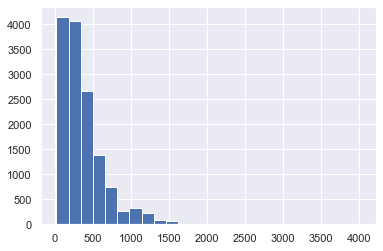

In [70]:
# What does the distribution of well depth look like?

df['Well Depth (ft)'].hist(bins=25)

<AxesSubplot:>

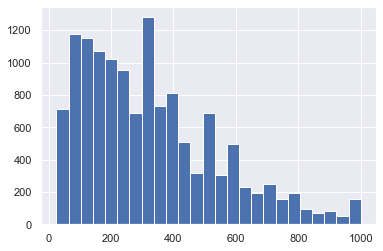

In [71]:
# How about the distribution of wells less than 1000 feet deep?

df_trim = df[df['Well Depth (ft)'] <=1000]
df_trim['Well Depth (ft)'].hist(bins=25)

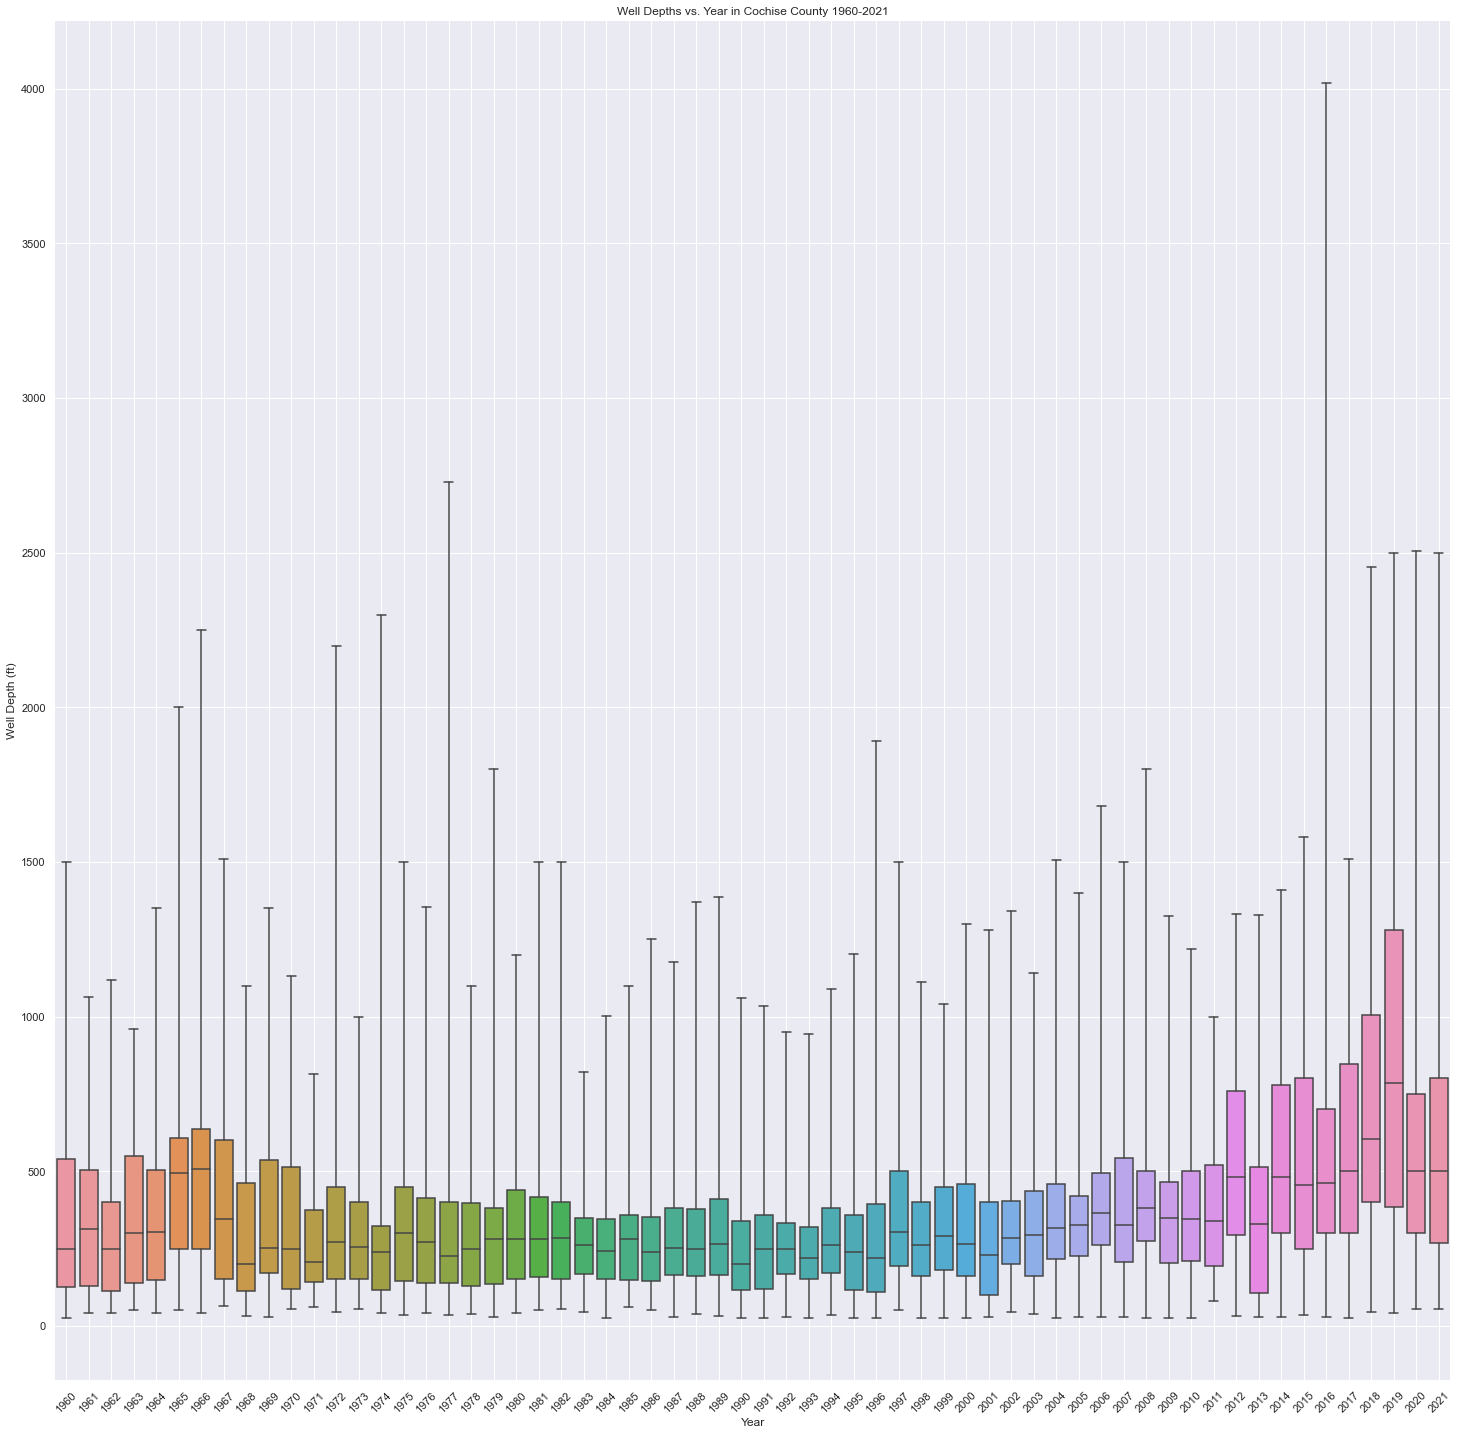

In [37]:
# First, let's look at all the wells since 1960

fig, ax = plt.subplots(figsize=(25,25))

sns.boxplot(x=df1960['Year'], y=df1960['Well Depth (ft)'], data=df1960, whis=[0,100])
ax.set_title("Well Depths vs. Year in Cochise County 1960-2021")
ax.set_ylabel("Well Depth (ft)")
ax.set_xlabel("Year")
sns.set(font_scale=1)
ax.xaxis.grid(True)
plt.xticks(rotation=45)
sns.despine(trim=True, left=True)

plt.show()

In [38]:
# how many wells belong to each sector?
print("Riverview: ", len(df_rv))
print("Arizona: ", len(df_az))
print("Oil: ", len(df_oil))
print("Mining: ", len(df_mining))
print("Energy: ", len(df_energy))
print("Federal: ", len(df_fed))
print("City: ", len(df_city))
print("Other Farm and Ranch: ", len(df_farm))
print("Residential: ", len(df_residential))


Riverview:  308
Arizona:  546
Oil:  139
Mining:  291
Energy:  206
Federal:  442
City:  91
Other Farm and Ranch:  3978
Residential:  8185


In [39]:
# Average well depth by sector?
print("Riverview: ", round(df_rv['Well Depth (ft)'].mean(),2))
print("AZ Dept or AZ State: ", round(df_az['Well Depth (ft)'].mean(),2))
print("Oil: ", round(df_oil['Well Depth (ft)'].mean(),2))
print("Mining: ", round(df_mining['Well Depth (ft)'].mean(),2))
print("Energy: ", round(df_energy['Well Depth (ft)'].mean(),2))
print("Federal: ", round(df_fed['Well Depth (ft)'].mean(),2))
print("City: ", round(df_city['Well Depth (ft)'].mean(),2))
print("Other Farm and Ranch: ", round(df_farm['Well Depth (ft)'].mean(),2))
print("Residential: ", round(df_residential['Well Depth (ft)'].mean(),2))

Riverview:  794.1
AZ Dept or AZ State:  311.05
Oil:  64.39
Mining:  737.8
Energy:  384.05
Federal:  520.05
City:  415.74
Other Farm and Ranch:  366.67
Residential:  330.35


<AxesSubplot:xlabel='Type'>

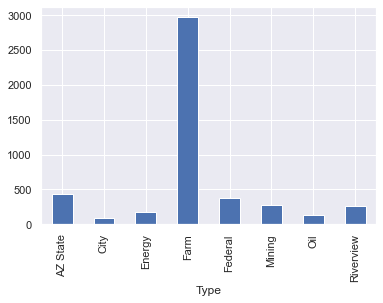

In [79]:
# let's see this all on a chart.
df1960.groupby(['Type']).size().plot.bar()
#df1960.plot.bar(x='Type', y=len(df1960['Owner']))

<AxesSubplot:xlabel='Type,Well Depth (ft)'>

Given the above chart, we see an increasing difference between the average water level and the well depth. 

Between 1970 and 1995-ish, the 10 year moving average well depth was decreasing. Why? Were people not worried about running out of water? Trying to save money on well drilling? 


Fundamental research needed:

Were there any lifting of regulations that occured between 1960 and today?

To explore:
The max values for years 2019-2021 look identical. Has there been a max well depth regulation put in place? What is the reasoning behind this? I suspect most of these are drilled by riverview, based on a "magic number" of depth they came up with.

What's going on with these wells that are ~40ft deep? Need to look at the actual water level. If the water level is much lower than the well depth, it may be bad data.

# III. Analysis:

<AxesSubplot:title={'center':'Total Wells Drilled Per Year since 1960'}, xlabel='Year'>

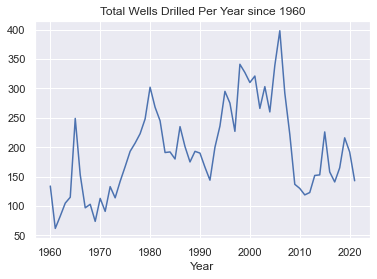

In [40]:
df_totbyyr = df1960.groupby(['Year']).size()
df_totbyyr.plot(title = "Total Wells Drilled Per Year since 1960")

# something isn't right here. Is there some data issues with applications dates from 1982?
# Before, when I was using "Drill Date" instead of "Application Date", we didn't have this spike at 1982. 

<AxesSubplot:title={'center':'Wells Drilled by Riverview since 1960'}, xlabel='Year'>

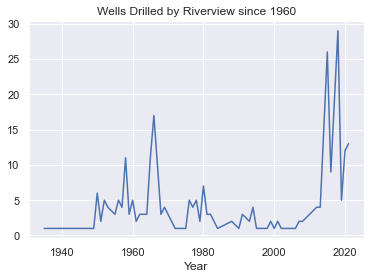

In [41]:
df_rvbyyr = df_rv.groupby(['Year']).size()
df_rvbyyr.plot(title = "Wells Drilled by Riverview since 1960")

<AxesSubplot:title={'center':'Percentage of total wells in county that were drilled by Riverview'}, xlabel='Year'>

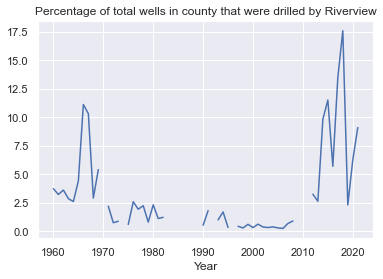

In [42]:
# Percentage of total wells in county that were drilled by Riverview:
df_rv_perc = (df_rvbyyr / df_totbyyr) * 100

df_rv_perc.plot(title = "Percentage of total wells in county that were drilled by Riverview")

<AxesSubplot:>

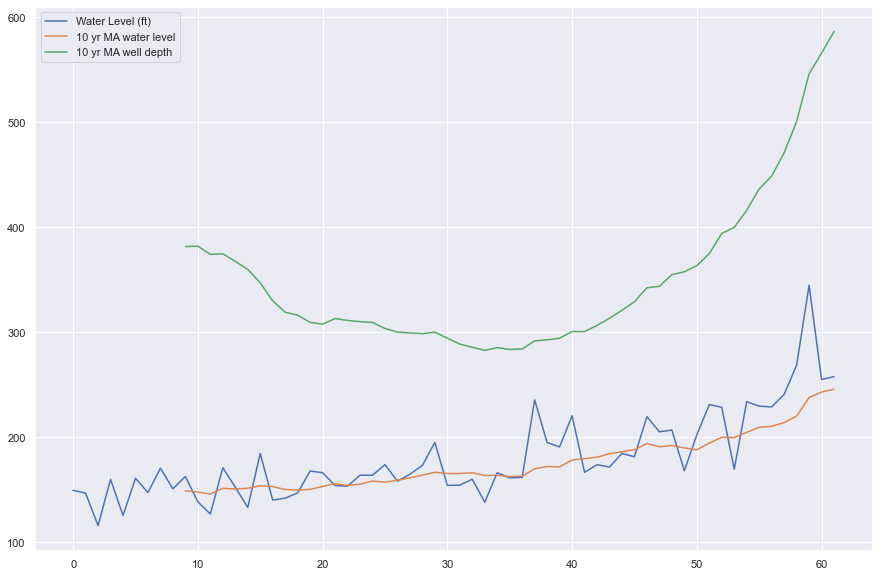

In [43]:
mean_waterlvl = df1960.groupby(['Year']).mean().reset_index()
mean_waterlvl.set_index('Year')

mean_waterlvl['10 yr MA water level'] = mean_waterlvl['Water Level (ft)'].rolling(10).mean()

mean_waterlvl['10 yr MA well depth'] = mean_waterlvl['Well Depth (ft)'].rolling(10).mean()

# why does it distort my plot when i try to add these as xticks?
xi = np.linspace(1960,2020,61)

mean_waterlvl[['Water Level (ft)', '10 yr MA water level', '10 yr MA well depth']].plot(figsize = (15,10))



### A larger difference between well depth and actual water level (charted below) represents greed and fear -- anticipation of ground water levels declining and a drive to monopolize access. 


<AxesSubplot:title={'center':'Absolute Difference in Water Level and Well Depth (ft)'}>

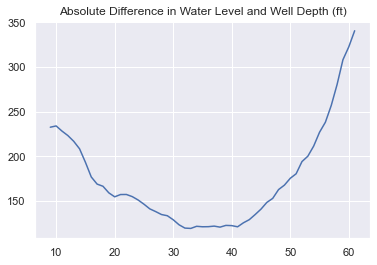

In [44]:
mean_difference = (mean_waterlvl['10 yr MA water level'] - mean_waterlvl['10 yr MA well depth']).abs()
mean_difference.plot(title="Absolute Difference in Water Level and Well Depth (ft)")

# FIXME: Add in yearly ticks on x axis